In [4]:
import numpy as np
import gym

new_step_api=True
# Create the environment
env = gym.make("MountainCar-v0")

/Users/henrycooper/anaconda3/lib/python3.11/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/henrycooper/anaconda3/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# now lets investigate the Environment. I belive the state is a contineous not discrete so we need to make it discrete

### 2 states, velocity and position so lets make a state bucked

In [55]:
state_bucket = (20,20) # position, velocity

state_bounds = list(zip(env.observation_space.low, env.observation_space.high))

print(state_bounds)

def discretize_state(state, state_buckets, state_bounds):
    ratios = [(state[i] - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0]) for i in range(len(state))]
    new_state = [int(ratio * (state_buckets[i] - 1)) for i, ratio in enumerate(ratios)]
    new_state = [min(max(new_state[i], 0), state_buckets[i] - 1) for i in range(len(new_state))]
    return tuple(new_state)


state = env.reset()
discrete_state = discretize_state(state, state_bucket, state_bounds)

print(state)
print(discrete_state)


[(-1.2, 0.6), (-0.07, 0.07)]
[-0.51141423  0.        ]
(7, 9)


### now that we have the discretized state, we gotta initialize the Q-table

In [40]:
q_table = np.zeros(state_bucket + (env.action_space.n,))

print(q_table)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [58]:
import random
def epsilon_greedy_policy(Qtable, state, epsilon):
    random_int = random.uniform(0, 1)
    if random_int > epsilon:
        action = np.argmax(Qtable[state])
    else:
        action = env.action_space.sample()
    return action

def greedy_policy(Qtable, state):
    return np.argmax(Qtable[state])

### now we will set the hyper parameters

In [57]:
# Training parameters
n_training_episodes = 10000
learning_rate = 0.1        
gamma = 0.95               # Discount factor
max_steps = 100             
decay_rate = 0.0005        

# Exploration parameters
max_epsilon = 1.0           
min_epsilon = 0.05

# Evaluation parameters
n_eval_episodes = 100
eval_seed = []       

In [ ]:
import matplotlib.pyplot as plt

def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, state_buckets, state_bounds, learning_rate, gamma):
    episode_rewards = []
    
    for episode in trange(n_training_episodes):
        # Decay epsilon using exponential decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
        # Reset the environment and discretize the initial state
        state = env.reset()
        discretized_state = discretize_state(state, state_buckets, state_bounds)
        done = False
        total_reward = 0

        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, discretized_state, epsilon)
            new_state, reward, done, info = env.step(action)
            discretized_new_state = discretize_state(new_state, state_buckets, state_bounds)
            total_reward += reward
            
            if not done:
                max_future_q = np.max(Qtable[discretized_new_state])
                current_q = Qtable[discretized_state + (action,)]
                new_q = (1 - learning_rate) * current_q + learning_rate * (reward + gamma * max_future_q)
                Qtable[discretized_state + (action,)] = new_q
            elif new_state[0] >= env.goal_position:
                Qtable[discretized_state + (action,)] = 0

            discretized_state = discretized_new_state
            if done:
                break
        
        # Store total reward per episode
        episode_rewards.append(total_reward)

    # Plot the rewards over episodes to check convergence
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()

    return Qtable


# Call the training function
q_table = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table, state_bucket, state_bounds, learning_rate, gamma)


 34%|███▎      | 3374/10000 [00:14<00:29, 222.28it/s]

In [61]:
def evaluate_agent(env, max_steps, n_eval_episodes, Qtable, seed, state_buckets, state_bounds):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        # Reset the environment with the given seed (if any), and discretize the initial state
        state = env.reset(seed=seed[episode]) if seed else env.reset()
        discretized_state = discretize_state(state, state_buckets, state_bounds)
        total_rewards_ep = 0
        
        for step in range(max_steps):
            # Select the best action (exploitation only, greedy policy)
            action = np.argmax(Qtable[discretized_state][:])
            
            # Take the action in the environment
            new_state, reward, done, info = env.step(action)
            
            # Discretize the new continuous state
            discretized_new_state = discretize_state(new_state, state_buckets, state_bounds)
            
            total_rewards_ep += reward
            
            # Update the state
            discretized_state = discretized_new_state
            
            if done:
                break
        
        # Store the total rewards for this episode
        episode_rewards.append(total_rewards_ep)
    
    # Calculate mean and standard deviation of rewards over all evaluation episodes
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

# Example usage of the modified evaluate_agent function:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, q_table, eval_seed, state_bucket, state_bounds)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")


Mean_reward=-200.00 +/- 0.00


Video saved to ./replay.gif


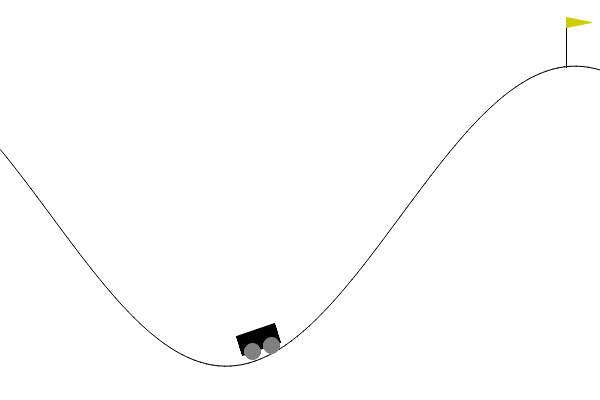

In [76]:
import os
import imageio
import numpy as np
from IPython.display import Image

def record_video(env, Qtable, video_path, fps, extra_frames=30):
    directory = os.path.dirname(video_path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
    
    images = []
    done = False
    # Reset the environment and discretize the initial state
    state = env.reset()
    discretized_state = discretize_state(state, state_bucket, state_bounds)
    images.append(env.render(mode='rgb_array'))
    
    while not done:
        # Select the best action using the max Q-value from the Q-table
        action = np.argmax(Qtable[discretized_state])

        # Take the action and get the next state, reward, and done flag (old Gym API)
        new_state, reward, done, info = env.step(action)
        
        # Discretize the new continuous state
        discretized_state = discretize_state(new_state, state_bucket, state_bounds)
        
        # Render and save the frame
        images.append(env.render(mode='rgb_array'))

    # Continue rendering extra frames after the episode ends (for a pause effect)
    for _ in range(extra_frames):
        images.append(env.render(mode='rgb_array'))

    # Save the video as a GIF with the correct duration per frame
    imageio.mimsave(video_path, [np.array(img) for img in images], duration=(1 / fps))
    print(f"Video saved to {video_path}")

# Record and display video
video_path = "./replay.gif"
video_fps = 30  # Setting a 30 FPS rate
record_video(env, q_table, video_path, video_fps, extra_frames=120)  # Adding 30 extra frames
Image(video_path)
